# Wall avoidance

Optimal


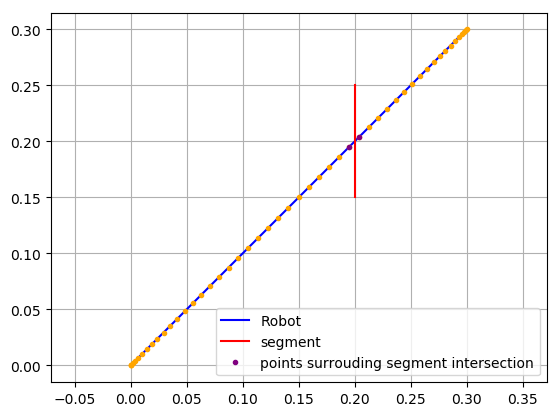

Total Distance: 0.4242640687119285
Total Acceleration: 11.221351694911416
Start: (0, 0)
Finish: (0.3, 0.3)
Crossed segment between time 31 and 32


In [60]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50               # simulation time
start = [0, 0]          # starting location
finish = [0.3, 0.3]     # ending location

segment_start = [0.2 0.15]   # x and y coordinates for segment left/top
segment_end = [0.2 0.25]     # x and y coordinates for segment right/bottom 


segment = [segment_start[1] segment_end[1];  
         segment_start[2] segment_end[2]]

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# Initial constraints
@constraint(m, x_A[:, 1] .== start) # Robot initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot initial velocity 

# Keep path away from line segments
# TODO: incorporate conditional constraints to prevent x_A from crossing segment
# a = [segment[1],segment[2]]
# b = [segment[3],segment[4]]
# for t in 1:time-1
#     c = [x_A[1,t], x_A[2,t]]
#     d = [x_A[1,t+1], x_A[2,t+1]]
#     if (intersection(a,b,c,d))
#        println("cross") 
#     end
# end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Get values of path
x_A = getvalue(x_A)
u_A = getvalue(u_A)


# True total distance traveled
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2 )
end

# True total acceleration
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (u_A[1,t+1]-u_A[1,t])^2 + (u_A[2,t+1]-u_A[2,t])^2) 
end


# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot segment
plot(segment[1,:], segment[2,:], color="red", label="segment")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Detect if path crosses segment or not
a = [segment[1],segment[2]]
b = [segment[3],segment[4]]
first_cross = 0
last_cross = 0
for t in 1:time-1
    c = [x_A[1,t], x_A[2,t]]
    d = [x_A[1,t+1], x_A[2,t+1]]
    if intersection(a,b,c,d) 
        first_cross = t
        last_cross = t+1
    end
end

# Output
println("Total Distance: ", d_tot_actual)
println("Total Acceleration: ", u_tot_actual)
println("Start: (", start[1],", ", start[2],")")
println("Finish: (", finish[1],", ", finish[2],")")

# Plot points surrounding section of path crossing segment
if first_cross > 0
    plot(x_A[1, first_cross:last_cross], x_A[2, first_cross:last_cross], ".", color="purple", label="points surrouding segment intersection")
    println("Crossed segment between time ",first_cross," and ", last_cross)
else
    println("Path does not cross segment")
end

# Formatting
axis("equal")           # make x and y scales equal
grid("on")
legend()
;

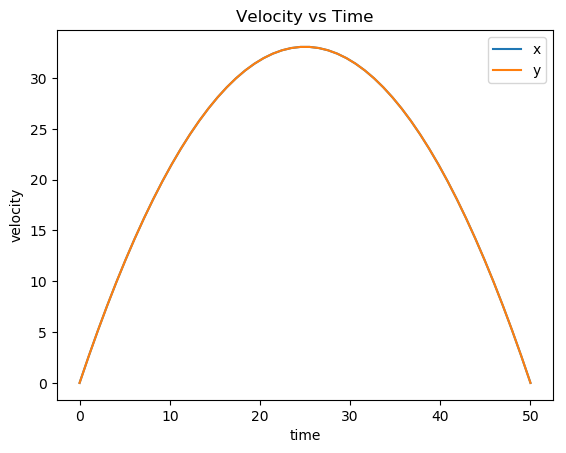

In [55]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x" )
plot(x[:], getvalue(v_A)[2,:], label="y" )
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

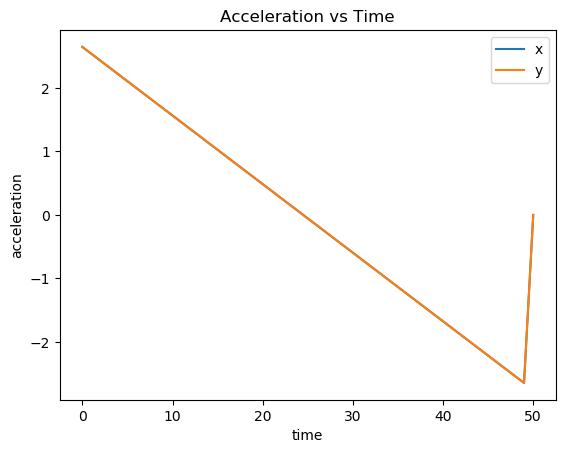

In [56]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y" )
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

In [21]:
function point_on_segment(a, b, c)
    # a and b end points of a segment, c point to check
    # only gets called if c is determined by orientation(a,b,c) to be collinear with ab
    # returns true if c on segment ab, false otherwise 
    if ( min(a[1], b[1]) <= c[1] && c[1] <= max(a[2], b[2]) )
        if ( min(a[2], b[2]) <= c[2] && c[2] <= max(a[2], b[2]) )
        return true
        end
    end
    return false
end
;

In [22]:
function orientation(a, b, c)
    # a and b end points of a segment, c point to check
    
    #slope1 = (b[2]-a[2])/(b[1]-a[1])
    #slope2 = (c[2]-b[2])/(c[1]-b[1])
    #val = slope1 - slope2
    
    val = (b[2]-a[2])*(c[1]-b[1]) - (c[2]-b[2])*(b[1]-a[1])
    if(val<0)
        return 1 # clockwise
    end
    if(val>0)
        return 2 # counterclockwise 
    end
    return 0 # slopes the same
    
end
;

In [23]:
function intersection(a, b, c, d)
    # a and b existing segment, c and d segment to check
    # returns true if intersection discovered, false otherwise
    
    # ab vs new segment test
    ab_vs_c = orientation(a,b,c)
    ab_vs_d = orientation(a,b,d)
    
    # new segment vs ab test
    cd_vs_a = orientation(c,d,a)
    cd_vs_b = orientation(c,d,b)
    
    # if both orientation tests are different, then segments cross 
    if(ab_vs_c != ab_vs_d && cd_vs_a != cd_vs_b)
        return true
    end
    
    # verify any collinearity does not result in crossing
    
    # c collinear with ab
    if(ab_vs_c == 0 && point_on_segment(a,b,c))
        return true
    end
    
    # d collinear with ab
    if(ab_vs_d == 0 && point_on_segment(a,b,d))
        return true
    end
    
    # a collinear with cd
    if(cd_vs_a == 0 && point_on_segment(c,d,a))
        return true
    end
    
    # b collinear with cd
    if(cd_vs_b == 0 && point_on_segment(c,d,b))
        return true
    end
    
    # if crossing not detected, return false
    return false   
    
end
;

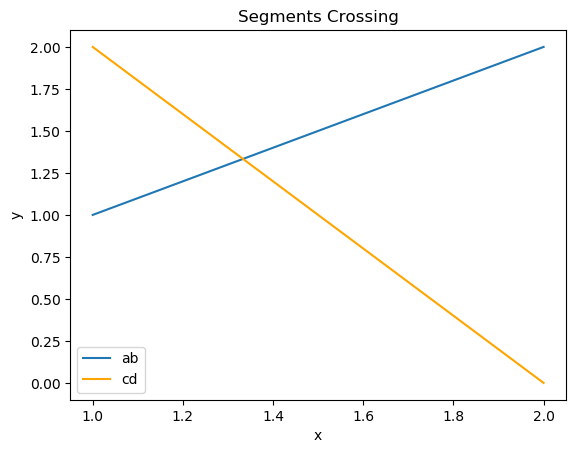

true


In [24]:
# Testing segment crossing
a = [1 1] # left point of ab
b = [2 2] # right point of ab
c = [2 0] # left point of cd
d = [1 2] # right point of cd

# segment ab
line1 = [a[1] b[1];
         a[2] b[2]]
# segment cd
line2 = [c[1] d[1];
         c[2] d[2]]

# Plot segments
plot(line1[1,:], line1[2,:], label="ab")
plot(line2[1,:], line2[2,:], label="cd", color="orange")

title("Segments Crossing")
xlabel("x")
ylabel("y")
legend()

println(intersection(a,b,c,d)) # determine if points cross or not and print result
;